### Preparing data

In [1]:
import os
import random
import shutil
import pandas as pd
import cv2
import numpy as np
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input,Add
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,ZeroPadding2D
from keras import regularizers
from keras.layers import LeakyReLU, ELU, ReLU
from keras.initializers import glorot_uniform
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from numpy import argmax
from keras.utils import to_categorical
from keras import applications

Using TensorFlow backend.


In [2]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [3]:
def lr_schedule(epoch):
    lrate = 0.00001
    if epoch > 35:
        lrate = 0.00005
    if epoch > 100:
        lrate = 0.00003
    return lrate

In [3]:
def createFolderIfNotExists(path):
    try:
        os.mkdir(path)
    except FileExistsError:
        #print("Directory data_generated already exists")
        return

In [32]:
DATASET_DIR = "C:\\Users\\ASUS\\Documents\\Proyectos\\pokedex\\pokemon"
numberAnomalies = 0
for category in os.listdir(DATASET_DIR):
    category_path = os.path.join(DataGenerator.DATASET_DIR, category)
    if not os.path.isdir(category_path):
        print("no es directorio valido")
        continue
    images = os.listdir(category_path)
    totalImgs = len(images)
    counter = 0
    path = "data"
    createFolderIfNotExists(path)
    for img in images:
        tempPath = path
        #print(counter / totalImgs)
        if(counter / totalImgs < 0.7):
            tempPath += "\\train"
        elif(counter / totalImgs < 0.85):
            tempPath += "\\test"
        else:
            tempPath += "\\validation"
        createFolderIfNotExists(tempPath)
        tempPath += "\\"+str(category)
        createFolderIfNotExists(tempPath)
        tempPath += "\\"+str(img)
        imgArr = cv2.imread("pokemon\\"+str(category)+"\\"+str(img))
        try:
            cv2.imwrite(tempPath, imgArr) 
        except:
            numberAnomalies += 1
                
        counter += 1
print("numberAnomalies: "+str(numberAnomalies))

numberAnomalies: 33


In [4]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [5]:
train_it = datagen.flow_from_directory('data\\train\\', class_mode='categorical', batch_size=32)
val_it = datagen.flow_from_directory('data\\validation\\', class_mode='categorical', batch_size=32)
test_it = datagen.flow_from_directory('data\\test\\', class_mode='categorical', batch_size=32)

Found 7529 images belonging to 149 classes.
Found 1524 images belonging to 149 classes.
Found 1604 images belonging to 149 classes.


In [6]:
pokemon_dictionary = dict(zip(train_it.class_indices.values(), train_it.class_indices.keys()))

In [8]:
bx,by = train_it.next()
datagen.fit(bx)
np.shape(by)

(32, 149)

In [87]:
np.shape(bx)

(32, 256, 256, 3)

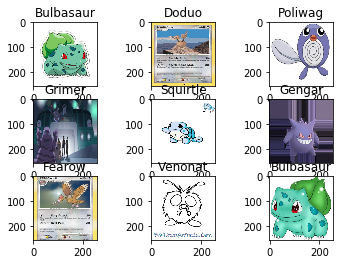

In [89]:
batch,y = train_it.next()
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    # plot raw pixel data
    plt.title(pokemon_dictionary[argmax(y[i])])
    plt.imshow(batch[i])

In [31]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(50, (3,3),input_shape=(256, 256, 3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(149, activation='sigmoid'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 256, 256, 50)      1400      
_________________________________________________________________
re_lu_21 (ReLU)              (None, 256, 256, 50)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 128, 128, 50)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 128)     57728     
_________________________________________________________________
re_lu_22 (ReLU)              (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 256)       295168    
__________

In [7]:
def CONV_BLOCK(X, f, filter1, filter2, filter3, s=2):
    X_shortcut = X
 
    X = Conv2D(filter1, (1, 1), strides = (s,s), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filter2, kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filter3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    X_shortcut = Conv2D(filter3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ID_BLOCK(X, f, filter1, filter2, filter3):
    X_shortcut = X

    X = Conv2D(filters = filter1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = filter2, kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = filter3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X

def ResNet150Pokemon():
    X_input = Input((256, 256, 3))

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = CONV_BLOCK(X, 3, 16, 16, 32, s=1)
    X = ID_BLOCK(X, 3, 16, 16, 32)
    X = ID_BLOCK(X, 3, 16, 16, 32)

    X = CONV_BLOCK(X, 3, 128, 128, 512)
    X = ID_BLOCK(X, 3, 128, 128, 512)
    X = ID_BLOCK(X, 3, 128, 128, 512)
    X = ID_BLOCK(X, 3, 128, 128, 512)

    X = CONV_BLOCK(X, 3, 256, 256, 1024)
    X = ID_BLOCK(X, 3, 256, 256, 1024)
    X = ID_BLOCK(X, 3, 256, 256, 1024)
    X = ID_BLOCK(X, 3, 256, 256, 1024)
    X = ID_BLOCK(X, 3, 256, 256, 1024)
    X = ID_BLOCK(X, 3, 256, 256, 1024)

    X = CONV_BLOCK(X, 3, 512, 512, 2048)
    X = ID_BLOCK(X, 3, 512, 512, 2048)
    X = ID_BLOCK(X, 3, 512, 512, 2048)

    X = AveragePooling2D((2,2))(X)

    X = Flatten()(X)
    X = Dense(149, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    model = Model(inputs = X_input, outputs = X)

    return model

In [8]:
model = ResNet150Pokemon()
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), metrics=['accuracy'])
model.fit_generator(train_it, steps_per_epoch=32, validation_data=val_it, validation_steps=16,epochs=110,callbacks=[LearningRateScheduler(lr_schedule)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/110
32/32 [==============================] - 33s 1s/step - loss: 6.1795 - acc: 0.0166 - val_loss: 5.9206 - val_acc: 0.0254
Epoch 2/110
32/32 [==============================] - 20s 610ms/step - loss: 5.7579 - acc: 0.0244 - val_loss: 5.7134 - val_acc: 0.0293
Epoch 3/110
32/32 [==============================] - 20s 622ms/step - loss: 5.6297 - acc: 0.0303 - val_loss: 5.5781 - val_acc: 0.0260
Epoch 4/110
32/32 [==============================] - 20s 611ms/step - loss: 5.5362 - acc: 0.0400 - val_loss: 5.4981 - val_acc: 0.0234
Epoch 5/110
32/32 [==============================] - 20s 613ms/step - loss: 5.4259 - acc: 0.0352 - val_loss: 5.4272 - val_acc: 0.0312
Epoch 6/110
32/32 [==============================] - 20s 612ms/step - loss: 5.4499 - acc: 0.0381 - val_loss: 5.3387 - val_acc: 0.0380
Epoch 7/110
32/32 [==============================] - 20s 614ms/step - loss: 5.4

32/32 [==============================] - 19s 606ms/step - loss: 3.7973 - acc: 0.2324 - val_loss: 5.5281 - val_acc: 0.0940
Epoch 58/110
32/32 [==============================] - 20s 610ms/step - loss: 3.6620 - acc: 0.2373 - val_loss: 5.6154 - val_acc: 0.0918
Epoch 59/110
32/32 [==============================] - 19s 600ms/step - loss: 3.4959 - acc: 0.2658 - val_loss: 5.0310 - val_acc: 0.1426
Epoch 60/110
32/32 [==============================] - 19s 608ms/step - loss: 2.7551 - acc: 0.3906 - val_loss: 5.1164 - val_acc: 0.1260
Epoch 61/110
32/32 [==============================] - 20s 616ms/step - loss: 2.7355 - acc: 0.3975 - val_loss: 4.8065 - val_acc: 0.1504
Epoch 62/110
32/32 [==============================] - 20s 620ms/step - loss: 2.6588 - acc: 0.3896 - val_loss: 4.8358 - val_acc: 0.1172
Epoch 63/110
32/32 [==============================] - 20s 614ms/step - loss: 2.7348 - acc: 0.3994 - val_loss: 4.9086 - val_acc: 0.1120
Epoch 64/110
32/32 [==============================] - 20s 627ms/step

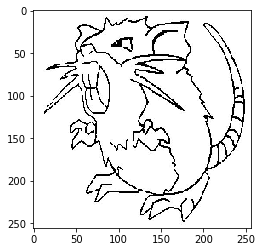

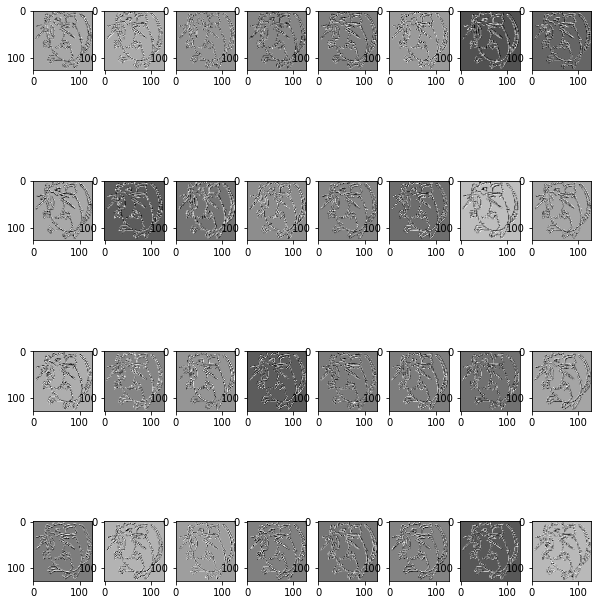

In [15]:
bx,by = test_it.next()
plt.imshow(bx[1])
layer_outputs = [layer.output for layer in model.layers][1:]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
            
activations = activation_model.predict(bx[1].reshape(1,256,256,3))
display_activation(activations, 8, 4, 2)

real pokemon:MrMime
predicted pokemon: Weezing


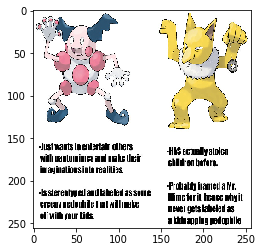

In [60]:
bx,by = test_it.next()
plt.imshow(bx[1])
print("real pokemon:" +str(pokemon_dictionary[argmax(by[1])]))
print("predicted pokemon: "+ str(pokemon_dictionary[argmax(model.predict(bx[1].reshape(1,256,256,3)))]))